In [1]:
import subprocess
import os
import TSED
import torch
from scipy.spatial.distance import cosine
import tiktoken
enc = tiktoken.encoding_for_model("gpt-4")
import os
from openai import OpenAI
import json

from transformers import AutoModel, AutoTokenizer
# Import our models. The package will take care of downloading the models automatically
tokenizer = AutoTokenizer.from_pretrained("princeton-nlp/sup-simcse-roberta-large")
model = AutoModel.from_pretrained("princeton-nlp/sup-simcse-roberta-large")

/Users/sina/Documents/GitHub_Local/uncovering_llm_generated_code/.venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Users/sina/Documents/GitHub_Local/uncovering_llm_generated_code/.venv/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [2]:
# with open('output/rewrite/gemini_flash/rewrite_csn_gpt-4o_gemini-1.5-flash_50.json', 'r') as file:
#     data = json.load(file)

In [3]:
# Directory containing the JSON files
directory_path = 'output/rewrite/gpt_mini'

# Initialize an empty list to store the combined data
data = []

# Iterate over all JSON files in the directory
for filename in os.listdir(directory_path):
    if filename.endswith('.json'):  # Process only JSON files
        file_path = os.path.join(directory_path, filename)
        # print(file_path)
        with open(file_path, 'r') as file:
            file_data = json.load(file)  # Load JSON content
            data.extend(file_data)  # Add content to 

In [ ]:
item = data[10]
texts = [item['code']]
texts.extend(item['rewrite'])

In [5]:
len(data)

600

In [6]:
def string_similarity(first, second):
	output = subprocess.check_output(["node", "string-similarity-wrapper.js", first, second], universal_newlines=True)
	
	score = float(output.split(" ")[-1])
	return score

In [7]:
def classify_package(item, num_rewrites, strategy):
	texts = [item['code']]
	texts.extend(item['rewrite'])

	sim_scores = []

	if strategy == 'simcse':
		inputs = tokenizer(texts, padding=True, truncation=True, return_tensors="pt")
		with torch.no_grad():
			embeddings = model(**inputs, output_hidden_states=True, return_dict=True).pooler_output

		for i in range(num_rewrites):
			sim = 1 - cosine(embeddings[0], embeddings[i+1])
			sim_scores.append(sim)

	elif strategy == 'string':
		for i in range(num_rewrites):
			sim = string_similarity(texts[0], texts[i+1])
			sim_scores.append(sim)

	elif strategy == 'tsed':
		for i in range(num_rewrites):
			sim = TSED.Calculate("python", texts[0], texts[i+1], 1.0, 0.8, 1.0)
			sim_scores.append(sim)
	else:
		print('ERROR. Invalid Strategy: "' + strategy + '"')
		return []

	return sim_scores

In [8]:
# print(f"Machine sample scores (simcse): {classify_package(data[0], 3, 'simcse')}") 
# print(f"Human sample scores(simcse): {classify_package(data[1], 3, 'simcse')}")


In [9]:
# print(f"Machine sample scores (tsed): {classify_package(data[0], 3, 'tsed')}")
# print(f"Machine sample scores (tsed): {classify_package(data[2], 3, 'tsed')}") 
# print(f"Machine sample scores (tsed): {classify_package(data[5], 3, 'tsed')}") 
# print(f"Machine sample scores (tsed): {classify_package(data[6], 3, 'tsed')}")
# print(f"Machine sample scores (tsed): {classify_package(data[9], 3, 'tsed')}") 
 

# print(f"Human sample scores(tsed): {classify_package(data[1], 3, 'tsed')}")
# print(f"Human sample scores(tsed): {classify_package(data[3], 3, 'tsed')}")
# print(f"Human sample scores(tsed): {classify_package(data[4], 3, 'tsed')}")
# print(f"Human sample scores(tsed): {classify_package(data[7], 3, 'tsed')}")
# print(f"Human sample scores(tsed): {classify_package(data[8], 3, 'tsed')}")

## Scoring the entire samples

In [10]:
import numpy as np
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from tqdm import tqdm  # Import tqdm for the progress bar

In [11]:
def scoring_process(strategy='simcse'):
    # Initialize lists to collect labels and scores
    labels = []
    scores = []

    # Choose the strategy for similarity computation
    strategy = strategy  # You can also use 'string' or 'tsed'

    # Iterate over the dataset with a progress bar
    for item in tqdm(data, desc="Processing items"):
        # Get the label (1 for machine, 0 for human)
        label = 1 if item['writer'] == 'machine' else 0
        labels.append(label)
        
        # Compute similarity scores using classify_package
        num_rewrites = len(item['rewrite'])
        sim_scores = classify_package(item, num_rewrites, strategy)
        
        # Average the similarity scores as per the formula
        avg_score = np.mean(sim_scores)
        scores.append(avg_score)

    # Convert lists to numpy arrays for compatibility
    labels = np.array(labels)
    scores = np.array(scores)

    # Compute ROC curve and AUC
    fpr, tpr, thresholds = roc_curve(labels, scores)
    roc_auc = auc(fpr, tpr)

    # Print AUC value
    print(f'AUC for strategy "{strategy}": {roc_auc:.4f}')

    # Plot ROC curve
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Diagonal line
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Receiver Operating Characteristic - {strategy}')
    plt.legend(loc="lower right")
    plt.show()

Processing items: 100%|██████████| 600/600 [06:28<00:00,  1.54it/s]

AUC for strategy "simcse": 0.6743


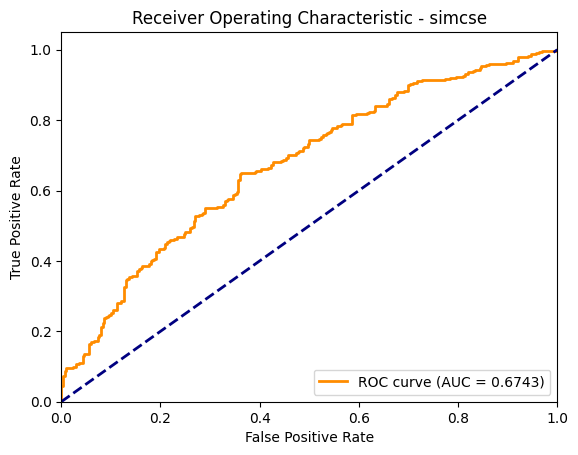

In [12]:
scoring_process(strategy='simcse')

Processing items:   0%|          | 0/600 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZER

AUC for strategy "string": 0.5971


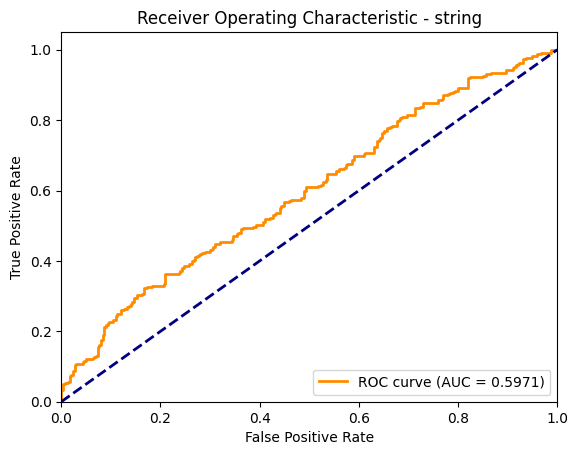

In [15]:
scoring_process(strategy='string')

Processing items:   0%|          | 0/600 [00:00<?, ?it/s]/Users/sina/Documents/GitHub_Local/uncovering_llm_generated_code/.venv/lib/python3.9/site-packages/tree_sitter/__init__.py:36: FutureWarning: Language(path, name) is deprecated. Use Language(ptr, name) instead.
  warn("{} is deprecated. Use {} instead.".format(old, new), FutureWarning)
Processing items: 100%|██████████| 600/600 [05:14<00:00,  1.91it/s]

AUC for strategy "tsed": 0.5332


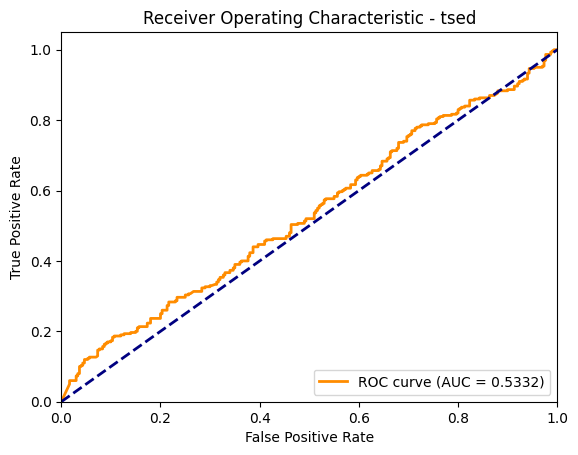

In [16]:
scoring_process(strategy='tsed')